# Pretrained Models and Prototypes

Recent approaches excel at continual learning benchmarks by avoiding the
catastrophic forgetting problem entirely.

In [ ]:
from typing import Dict, Tuple

import torch
from capymoa.base import BatchClassifier
from capymoa.classifier import Finetune
from capymoa.ocl.ann import WNPerceptron
from capymoa.ocl.datasets import SplitCIFAR100ViT
from capymoa.ocl.evaluation import ocl_train_eval_loop
from capymoa.ocl.strategy import ExperienceReplay
from capymoa.stream import Schema
from torch import Tensor, nn
from torch.optim import Adam

from plot import plot_multiple, table

## ViT Datasets

CapyMOA includes a CIFAR10 and CIFAR100 variants that have been pre-encoded using a powerful pre-trained Vision Transformer (ViT) model.


> 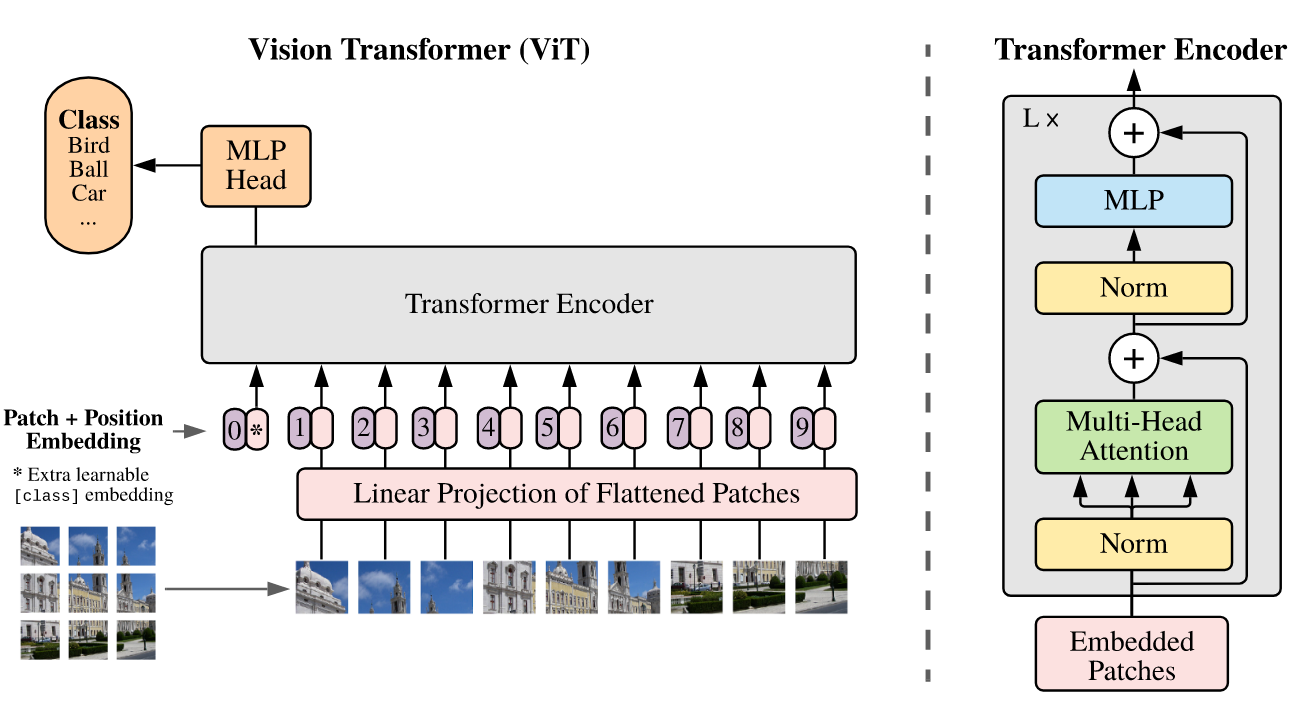
>
> (Source [1]). The image is split into 16x16 patches which are then linearly
> embedded into a sequence of tokens. The transformer processes these tokens to
> perform image classification tasks.

---
1. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X.,
   Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S.,
   Uszkoreit, J., & Houlsby, N. (2021). An Image is Worth 16x16 Words:
   Transformers for Image Recognition at Scale (No. arXiv:2010.11929). arXiv.
   http://arxiv.org/abs/2010.11929


In [ ]:
scenario = SplitCIFAR100ViT()

## Methods

### NCM

* **The Nearest Class Mean (NCM) algorithm** is a simple learning method that performs well with high-quality features.
* NCM "learns" by calculating the **mean of each class in the embedding space**, creating a prototype for each class.
* During inference, the algorithm measures the **distance of an instance's embedding to each class prototype**, assigning the instance to the class with the closest prototype.
* NCM is similar to k-Nearest Neighbors (kNN) but stores only one prototype per class instead of all training samples.
* The effectiveness of NCM highlights the quality of pre-trained representations learned by vision transformers.

Try [`capymoa.ocl.strategy.NCM`](https://capymoa.org/api/modules/capymoa.ocl.strategy.NCM.html).

Uses the incremental cumulative average update rule for each class prototype:

$$
\mu_{i+b} = \frac{n\mu_i + b\bar{\mathbf{x}}}{i + b}
$$

Where:
- $\mu_n$ is the prototype for a class at time $i$.
- $b$ is the batch size of the new samples.
- $\bar{\mathbf{x}}$ is the mean of the new samples.


In [ ]:
def batch_cumulative_mean(
    batch: Tensor, count: int, mean: Tensor
) -> Tuple[int, Tensor]:
    """Update cumulative mean and count.

    :param batch: Current batch of data. Shape (batch_size, num_features).
    :param count: Current count of samples processed.
    :param mean: Current cumulative mean of the data. Shape (num_features,).
    :return: Updated count and cumulative mean.
    """
    batch_size = batch.size(0)
    if batch_size == 0:
        return count, mean
    new_count = count + batch_size
    updated_mean = (count * mean + batch.sum(0)) / new_count
    return new_count, updated_mean


class NCM(BatchClassifier):
    _dtype = torch.float32

    def __init__(
        self,
        schema: Schema,
        device: torch.device | str = torch.device("cpu"),
    ):
        super().__init__(schema)
        n_classes = schema.get_num_classes()
        n_feats = schema.get_num_attributes()
        self.device = device
        self.class_counts = torch.zeros((n_classes,), device=device, dtype=torch.int64)
        self.class_means = torch.zeros((n_classes, n_feats), device=device)

    @torch.no_grad()
    def batch_train(self, x: Tensor, y: Tensor) -> None:
        # Update mean and count
        for i in range(self.schema.get_num_classes()):
            mask = y == i
            self.class_counts[i], self.class_means[i] = batch_cumulative_mean(
                batch=x[mask],
                count=int(self.class_counts[i].item()),
                mean=self.class_means[i],
            )

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        # Calculate distances to class means
        distances = torch.cdist(x.unsqueeze(0), self.class_means.unsqueeze(0))
        distances = distances.squeeze(0)

        # Convert distances to pseudo-probabilities. Using the inverse weighted
        # distance method.
        inv_distances = 1 / (1 + distances)
        probabilities = inv_distances / inv_distances.sum(dim=1, keepdim=True)
        return probabilities

### Gaussian Discriminant Analysis (SLDA)

Moving beyond NCM, lets consider each class's spread or variance of the classes
in the embedding space.

We implement a streaming/incremental version of linear discriminant analysis
(1). Others have explored other types of streaming/incremental gaussian
discriminant analysis for continual learning (2,3,4). Performance between these
methods does not vary greatly, but they do have differences. Usually the main
difference is in **pre-processing the embeddings** before applying the streaming
GDA algorithm.

Try [`capymoa.ocl.strategy.SLDA`](https://capymoa.org/api/modules/capymoa.ocl.strategy.SLDA.html).

Uses welford's algorithm to compute the mean and covariance online:

$$
\begin{align*}
\mu_{i+b} &= \mu_i + \frac{1}{i+b}(\bar{\mathbf{x}} - \mu_i) \\
\Sigma_{i+b} &= \Sigma_i + \frac{1}{i+b}(\bar{\mathbf{x}} - \mu_i)(\bar{\mathbf{x}} - \mu_{i+b})^T
\end{align*}
$$

Where:
- $\mu_i$ is the mean for a class at time $i$.
- $\Sigma_i$ is the covariance for a class at time $i$.
- $b$ is the batch size of the new samples.


---
1. Hayes, T. L., & Kanan, C. (2020). **Lifelong Machine Learning with Deep
   Streaming Linear Discriminant Analysis.** CLVision Workshop at CVPR 2020, 1–15.
2. McDonnell, M. D., Gong, D., Parvaneh, A., Abbasnejad, E., & van den Hengel,
   A. (2023). **RanPAC: Random projections and pre-trained models for continual
   learning**. In A. Oh, T. Naumann, A. Globerson, K. Saenko, M. Hardt, & S.
   Levine (Eds.), Advances in neural information processing systems 36: Annual
   conference on neural information processing systems 2023, NeurIPS 2023, new
   orleans, LA, USA, december 10—16, 2023.
   http://papers.nips.cc/paper_files/paper/2023/hash/2793dc35e14003dd367684d93d236847-Abstract-Conference.html
3. Goswami, D., Liu, Y., Twardowski, B., & Weijer, J. van de. (2023). **FeCAM:
   Exploiting the Heterogeneity of Class Distributions in Exemplar-Free
   Continual Learning.** In A. Oh, T. Naumann, A. Globerson, K. Saenko, M. Hardt,
   & S. Levine (Eds.), Advances in Neural Information Processing Systems 36:
   Annual Conference on Neural Information Processing Systems 2023, NeurIPS
   2023, New Orleans, LA, USA, December 10—16, 2023.
   http://papers.nips.cc/paper\_files/paper/2023/hash/15294ba2dcfb4521274f7aa1c26f4dd4-Abstract-Conference.html
4. Prabhu, A., Sinha, S., Kumaraguru, P., Torr, P. H. S., Sener, O., & Dokania,
   P. K. (2024). **RanDumb: A Simple Approach that Questions the Efficacy of
   Continual Representation Learning**(No. arXiv:2402.08823). arXiv.
   http://arxiv.org/abs/2402.08823
5. Momeni, S., Mazumder, S., & Liu, B. (2025). **Continual learning using a
   kernel-based method over foundation models.** In T. Walsh, J. Shah, & Z. Kolter
   (Eds.), AAAI-25, sponsored by the association for the advancement of
   artificial intelligence, february 25—March 4, 2025, philadelphia, PA, USA
   (pp. 19528–19536). AAAI Press. https://doi.org/10.1609/AAAI.V39I18.34150

In [ ]:
def batch_cumulative_covariance(
    batch: Tensor, count: int, mean: Tensor, covariance: Tensor
) -> Tuple[int, Tensor, Tensor]:
    """Update cumulative count, mean, and covariance with batch **Welford's** algorithm.

    See:
    * "Algorithms for calculating variance"
      https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online

    * "python (numpy) implementation of welford algorithm"
      https://github.com/nickypro/welford-torch

    :param batch: A batch of features ``(batch size, num features)``
    :param count: Current count of samples. Initially zero.
    :param mean: Current mean of samples ``(num_features,)``. Initially zero.
    :param covariance: Covariance matrix ``(num_features, num_features)``. Initially zero.
    :return: Updated count, mean, and covariance.
    """
    batch_size = batch.size(0)
    if batch_size == 0:
        return count, mean, covariance
    new_count = count + batch_size
    new_mean = (count * mean + batch.sum(0)) / new_count
    cov_update = torch.einsum("ni,nj->ij", batch - mean, batch - new_mean)
    covariance = (count * covariance + cov_update) / new_count
    return new_count, new_mean, covariance


class SLDA(BatchClassifier):
    """Streaming Linear Discriminant Analysis (SLDA).

    SLDA incrementally accumulates the mean of each class and a joint mean and
    covariance for all classes. Note that this method does not gracefully forget
    and may not handle concept drift well.

    [Hayes20]_ uses SLDA ontop of a pre-trained model to perform continual
    learning. See [WikipediaILDA]_ and [Ghassabeh2015]_ for more details on
    incremental LDA outside of continual learning.

    ..  [Hayes20] Hayes, T. L., & Kanan, C. (2020). Lifelong Machine Learning with Deep
        Streaming Linear Discriminant Analysis. CLVision Workshop at CVPR 2020, 1–15.
    ..  [Ghassabeh2015] Ghassabeh, Y. A., Rudzicz, F., & Moghaddam, H. A. (2015). Fast incremental
        LDA feature extraction. Pattern Recognition, 48(6), 1999-2012.
    ..  [WikipediaILDA] https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Incremental_LDA
    """

    def __init__(
        self,
        schema: Schema,
        pre_processor: nn.Module = nn.Identity(),
        num_features: int | None = None,
        ridge: float = 1e-6,
        device: torch.device | str = torch.device("cpu"),
    ):
        """Initialize a SLDA classifier.

        :param schema: Describes the shape and type of the data.
        :param pre_processor: A pre-processing module to apply to the input
            data, defaults to an identity module.
        :param num_features: Number of features once pre-processed, defaults to
            the number of attributes in the schema.
        :param ridge: Ridge regularization term to avoid singular covariance matrix,
            defaults to 1e-6.
        :param device: Device to run the model on, defaults to CPU.
        """
        super().__init__(schema)
        self.pre_processor = pre_processor.to(device)
        self.n_classes = schema.get_num_classes()
        self.n_feats = num_features or schema.get_num_attributes()
        self.device = torch.device(device)

        # Class means and counts
        self.class_counts = torch.zeros((self.n_classes,), device=device)
        self.class_means = torch.zeros((self.n_classes, self.n_feats), device=device)

        # Joint cumulative mean and covariance
        self.count = 0
        self.mean = torch.zeros(self.n_feats, device=device)
        self.covariance = torch.eye(self.n_feats, device=device)
        self.ridge = torch.eye(self.n_feats, device=device) * ridge

    @torch.no_grad()
    def batch_train(self, x: Tensor, y: Tensor) -> None:
        x = self.pre_processor(x)

        # Update class means and counts
        for i in range(self.schema.get_num_classes()):
            self.class_counts[i], self.class_means[i] = batch_cumulative_mean(
                x[y == i], int(self.class_counts[i]), self.class_means[i]
            )

        # Update joint cumulative mean and covariance
        self.count, self.mean, self.covariance = batch_cumulative_covariance(
            x, self.count, self.mean, self.covariance
        )

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        # Return uniform probabilities if no training has been done
        if self.count == 0:
            return torch.full(
                (x.size(0), self.n_classes),
                1.0 / self.n_classes,
                dtype=self.x_dtype,
                device=self.device,
            )

        x = self.pre_processor(x)
        covariance = self.covariance / self.count + self.ridge
        weights: Tensor = torch.linalg.solve(covariance, self.class_means.T).T
        bias = -0.5 * (self.class_means @ weights.T).diagonal()
        bias += torch.log(self.class_counts / self.count)
        scores = x @ weights.T
        return torch.softmax(scores, dim=1)

#### RanPAC and Pre-Processing

RanPAC (McDonnell et al., 2023) uses random fourier features to improve the
linear separability of features.

> 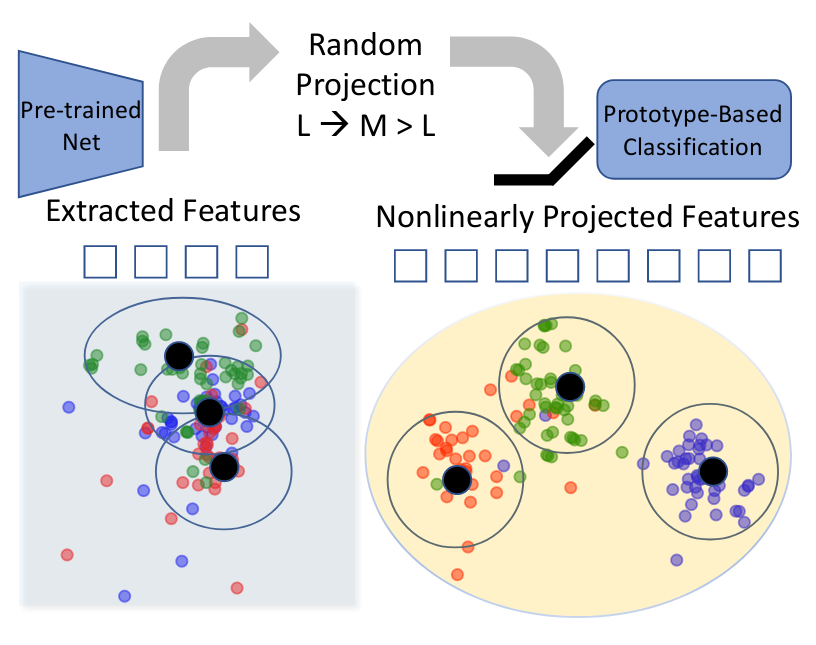
>
> (Source [1]). Show how random projections can
> improve the linear separability of features using t-SNE visualization.

---
1.  McDonnell, M. D., Gong, D., Parvaneh, A., Abbasnejad, E., & van den Hengel,
   A. (2023). **RanPAC: Random projections and pre-trained models for continual
   learning**. In A. Oh, T. Naumann, A. Globerson, K. Saenko, M. Hardt, & S.
   Levine (Eds.), Advances in neural information processing systems 36: Annual
   conference on neural information processing systems 2023, NeurIPS 2023, new
   orleans, LA, USA, december 10—16, 2023.
   http://papers.nips.cc/paper_files/paper/2023/hash/2793dc35e14003dd367684d93d236847-Abstract-Conference.html


In [ ]:
class RandomProjection(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.projection = nn.Linear(in_features, out_features, bias=False)
        self.projection.weight.data.normal_()
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        x = self.relu(x)
        return x

## Results

In [ ]:
from capymoa.base import Classifier
from capymoa.ocl.datasets import _BuiltInCIScenario
from capymoa.ocl.evaluation import OCLMetrics


def run(scenario: _BuiltInCIScenario, learner: Classifier) -> OCLMetrics:
    return ocl_train_eval_loop(
        learner,
        scenario.train_loaders(128),
        scenario.test_loaders(128),
        progress_bar=True,
        continual_evaluations=1,
        eval_window_size=128 * 3,
    )

In [ ]:
schema = scenario.schema
results: Dict[str, OCLMetrics] = {}
results["NCM"] = run(scenario, NCM(schema, device="cuda"))
results["SLDA"] = run(scenario, SLDA(schema, device="cuda"))
results["ER"] = run(
    scenario,
    ExperienceReplay(Finetune(schema, WNPerceptron, lambda p: Adam(p, 0.01)), 1_000),
)
results["RanPAC"] = run(
    scenario,
    SLDA(
        schema,
        pre_processor=RandomProjection(schema.get_num_attributes(), 5_000),
        num_features=5_000,
        ridge=0.001,  # More features require more regularization
        device="cuda",
    ),
)

In [ ]:
fig, ax = plot_multiple(results, acc_online=True, acc_seen=True)
ax.set_title(f"{scenario}")
table(results)

**Observations:**
* RanPAC performs the best by a small margin.
* SLDA is slightly worse but more efficient.
* NCM does surprisingly well, given its simplicity.
* ER exhibits the most forgetting, as expected.
* All methods have good online performance.

**Methods:**
* **RanPAC**: Random Projections and Pre-trained Models for Continual Learning
* **SLDA**: Streaming Linear Discriminant Analysis
* **NCM**: Nearest Class Mean
* **ER**: Experience Replay (baseline)

An interesting feature of cumulative updates is that the order and composition of
tasks does **NOT** matter. The final model will be the same regardless of
the order of tasks.

Note how the final accuracy is the same for both runs:

In [ ]:
stream_a = SplitCIFAR100ViT(seed=0)
print("Scenario A schedule: ", stream_a.task_schedule)
stream_b = SplitCIFAR100ViT(seed=1)
print("Scenario B schedule: ", stream_b.task_schedule)

results = {}
results["A: SLDA"] = run(stream_a, SLDA(stream_a.schema, device="cuda"))
results["B: SLDA"] = run(stream_b, SLDA(stream_b.schema, device="cuda"))
table(results)